# Guitar Chord Identifier Model

### Import Packages

In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers
from tensorflow.keras.models import load_model

### Step 1: Preprocessing

#### Create a Dataframe of the Chord Audio Files

In [3]:
# Create a list that contains the path names
folder_paths = ["data/a", "data/am", "data/bm", "data/c", "data/d", "data/dm", "data/e", "data/em", "data/f", "data/g"]

# Dataframe
audio_df = pd.DataFrame(columns=['File', 'Duration', 'Sample Rate', 'Audio Samples', 'File Path', 'Chord'])

In [4]:
# Initialize an empty list to store the data
data = []

# Loop through the folders and obtain each .wav file for a chord
for chord_folder in folder_paths:
    # Extract chord name from the folder path
    chord_name = os.path.basename(chord_folder)
    
    for chord_wav_name in os.listdir(chord_folder):
        full_file_path = os.path.join(chord_folder, chord_wav_name)
        y, sr = librosa.load(full_file_path)
        duration = librosa.get_duration(y=y, sr=sr)
        data.append({'File': chord_wav_name, 'Duration': duration, 'Sample Rate': sr, 'Audio Sample': y, 'File Path': full_file_path, 'Chord': chord_name})

# Convert the list into a DataFrame
audio_df = pd.DataFrame(data)

print(audio_df)

          File  Duration  Sample Rate  \
0      a44.wav  1.838503        22050   
1      a50.wav  2.061361        22050   
2      a78.wav  1.944626        22050   
3     a123.wav  1.602177        22050   
4     a137.wav  1.706667        22050   
...        ...       ...          ...   
1995   g67.wav  1.854014        22050   
1996   g73.wav  1.746531        22050   
1997  g198.wav  1.671837        22050   
1998  g173.wav  2.902494        22050   
1999  g167.wav  3.018594        22050   

                                           Audio Sample        File Path Chord  
0     [-0.00013691495, -7.487374e-05, -4.00946e-06, ...   data/a/a44.wav     a  
1     [-0.00011795966, -0.00017877144, -0.0001849309...   data/a/a50.wav     a  
2     [0.000108509455, 0.00020742104, 0.00022959543,...   data/a/a78.wav     a  
3     [-0.0024000388, -0.0039410237, -0.0027923286, ...  data/a/a123.wav     a  
4     [0.0012074066, 0.00086773233, -0.00046838168, ...  data/a/a137.wav     a  
...                  

#### Test: Display the Waveforms

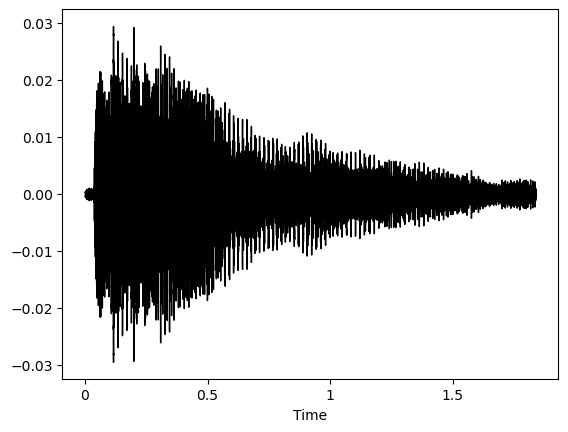

In [5]:
librosa.display.waveshow(audio_df.at[0, 'Audio Sample'], sr=audio_df.at[0, 'Sample Rate'], axis='time', color='black')

#### Function to Get Audio Features From a Single Audio .WAV

In [6]:
def padding(array, xx, yy):
    """
    :param array: numpy array
    :param xx: desired height
    :param yy: desirex width
    :return: padded array
    """
    h = array.shape[0]
    w = array.shape[1]
    a = max((xx - h) // 2,0)
    aa = max(0,xx - a - h)
    b = max(0,(yy - w) // 2)
    bb = max(yy - b - w,0)
    return np.pad(array, pad_width=((a, aa), (b, bb)), mode='constant')

def generate_features(audio_sample):
    max_size = 2799  # Define your max audio feature width
    n_mfcc = 13  # Number of MFCC coefficients

    # Extract features
    stft = padding(np.abs(librosa.stft(y=audio_sample, n_fft=255, hop_length=512)), 128, max_size)
    mfccs = padding(librosa.feature.mfcc(y=audio_sample, sr=sr, n_mfcc=n_mfcc), 128, max_size)
    spec_centroid = librosa.feature.spectral_centroid(y=audio_sample, sr=sr)
    chroma_stft = librosa.feature.chroma_stft(y=audio_sample, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=audio_sample, sr=sr)

    image = np.array([padding(normalize(spec_bw),1, max_size)]).reshape(1, max_size)
    image = np.append(image, padding(normalize(spec_centroid),1, max_size), axis=0) 

    for i in range(0,9):
        image = np.append(image,padding(normalize(spec_bw),1, max_size), axis=0)
        image = np.append(image, padding(normalize(spec_centroid),1, max_size), axis=0)
        image = np.append(image, padding(normalize(chroma_stft),12, max_size), axis=0)
        
    image = np.dstack((image,np.abs(stft)))
    image = np.dstack((image,mfccs))
    return image

#### Small Test on One Audio File

In [8]:
# small test
index_to_use = 0  # Change this index as needed
audio_sample = audio_df.at[index_to_use, 'Audio Sample']
sample_rate = audio_df.at[index_to_use, 'Sample Rate']

y, sr = librosa.load("data/a/a1.wav")

# Generate features
feature_array = generate_features(y)

# Check the shape of the feature array
print("Feature array shape:", feature_array.shape)

Feature array shape: (128, 2799, 3)


#### Extracting Features from Every Audio File in the Data Frame (Stored in 'X')

In [10]:
# Initialize an empty list to store the features
features_list = []

# Loop through each row in the DataFrame
for index, row in audio_df.iterrows():
    # Extract audio sample and sample rate
    audio_sample = row['Audio Sample']
    sample_rate = row['Sample Rate']
    
    # Generate features for the current audio sample
    features = generate_features(audio_sample)
    
    # Append the features to the list
    features_list.append(features)

# Convert the list of features into a numpy array
X = np.array(features_list)

# Check the shape of the feature array
print("Features array shape:", X.shape)

Features array shape: (2000, 128, 2799, 3)


#### Extracting the Corresponding Chord (Target) for Each Audio File in the Data Frame (Stored in 'y')

In [12]:
# Initialize an empty list to store the target chord labels
target_chords = []

# Loop through the DataFrame rows
for index, row in audio_df.iterrows():
    # Extract the chord label from the 'Chord' column
    chord_label = row['Chord']
    
    # Append the chord label to the target list
    target_chords.append(chord_label)

# Convert the target list to a numpy array
y_cat = np.array(target_chords)

# Check the shape of the target array
print("Target array shape:", y_cat.shape)

Target array shape: (2000,)


#### Convert Categorical Labels to Numerical Labels

In [13]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_cat)

# Labels 0-9 are associated with the following categorical labels:
print(label_encoder.classes_)

['a' 'am' 'bm' 'c' 'd' 'dm' 'e' 'em' 'f' 'g']


#### Extract training, testing, and validation sets

In [9]:
# Random seed for reproducibility
seed = 42

# Split once to get the test and training set
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y)

# Split again to get the validation set from the temporary set
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed, stratify=y_temp)

print(X_train.shape, X_test.shape, X_val.shape, len(y_train), len(y_test), len(y_val))

(1400, 128, 2799, 3) (300, 128, 2799, 3) (300, 128, 2799, 3) 1400 300 300


#### Normalize the data

In [11]:
# from sklearn.preprocessing import MinMaxScaler

# # Reshape the input data to original shape
# X_train_reshaped = X_train.reshape(-1, 128, 2799, 3)
# X_val_reshaped = X_val.reshape(-1, 128, 2799, 3)
# X_test_reshaped = X_test.reshape(-1, 128, 2799, 3)

# # Normalize each channel separately
# for i in range(3):  # Assuming 3 channels (RGB)
#     channel_train = X_train_reshaped[:, :, :, i]
#     channel_val = X_val_reshaped[:, :, :, i]
#     channel_test = X_test_reshaped[:, :, :, i]
    
#     # Min-max scaling for each channel
#     scaler = MinMaxScaler()
#     channel_train_normalized = scaler.fit_transform(channel_train.reshape(-1, 1)).reshape(channel_train.shape)
#     channel_val_normalized = scaler.transform(channel_val.reshape(-1, 1)).reshape(channel_val.shape)
#     channel_test_normalized = scaler.transform(channel_test.reshape(-1, 1)).reshape(channel_test.shape)
    
#     # Assign the normalized channel back to the original array
#     X_train_reshaped[:, :, :, i] = channel_train_normalized
#     X_val_reshaped[:, :, :, i] = channel_val_normalized  # Correct assignment for validation dataset
#     X_test_reshaped[:, :, :, i] = channel_test_normalized  # Correct assignment for test dataset

# # Now your data is normalized while maintaining the original shape


### Step 2: CNN Model

#### Create and Compile Model

In [12]:
# Create model
input_shape = feature_array.shape
CNNmodel = models.Sequential()
CNNmodel.add(layers.Conv2D(32, (5, 5), activation='relu', input_shape=input_shape))
CNNmodel.add(layers.MaxPooling2D((2, 2)))
CNNmodel.add(layers.Dropout(0.2))
CNNmodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
CNNmodel.add(layers.MaxPooling2D((2, 2)))
CNNmodel.add(layers.Dropout(0.2))
CNNmodel.add(layers.Conv2D(128, (3, 3), activation='relu'))
CNNmodel.add(layers.Flatten())
CNNmodel.add(layers.Dense(64, activation='relu'))
CNNmodel.add(layers.Dropout(0.2))
CNNmodel.add(layers.Dense(32, activation='relu'))
CNNmodel.add(layers.Dense(24, activation='softmax'))

# Compile model
CNNmodel.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

# Fit model
history = CNNmodel.fit(X_train, y_train, epochs=25, validation_data=(X_val, y_val))

Epoch 1/25


2024-03-21 23:02:21.838569: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


44/44 [==============================] - 334s 8s/step - loss: 8.8120 - accuracy: 0.0729 - val_loss: 2.8924 - val_accuracy: 0.1000
Epoch 2/25
44/44 [==============================] - 326s 7s/step - loss: 2.8252 - accuracy: 0.1157 - val_loss: 2.5991 - val_accuracy: 0.1467
Epoch 3/25
44/44 [==============================] - 324s 7s/step - loss: 2.4174 - accuracy: 0.1579 - val_loss: 2.1840 - val_accuracy: 0.2533
Epoch 4/25
44/44 [==============================] - 340s 8s/step - loss: 2.2157 - accuracy: 0.2264 - val_loss: 1.9711 - val_accuracy: 0.3300
Epoch 5/25
44/44 [==============================] - 348s 8s/step - loss: 2.0578 - accuracy: 0.2800 - val_loss: 1.8828 - val_accuracy: 0.3033
Epoch 6/25
44/44 [==============================] - 365s 8s/step - loss: 1.9251 - accuracy: 0.3271 - val_loss: 1.8300 - val_accuracy: 0.3867
Epoch 7/25
44/44 [==============================] - 351s 8s/step - loss: 1.7506 - accuracy: 0.3779 - val_loss: 1.6095 - val_accuracy: 0.4133
Epoch 8/25
44/44 [======

In [15]:
# Save the model
CNNmodel.save("saved_models/cnn_attempt_4.h5")

In [16]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('saved_models/cnn_attempt_4.h5')

# Now you can use the loaded model for inference or further evaluation

# Evaluate model on the testing dataset
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)

10/10 [==============================] - 14s 1s/step - loss: 0.4080 - accuracy: 0.8467
Test loss: 0.4079853892326355
Test accuracy: 0.846666693687439


### Step 3: Test on own files

In [21]:
model = load_model('saved_models/cnn_attempt_4.h5')

for i in range(1, 22):
    # Construct the file path for each audio file
    # c_test contains audio files we recorded
    audio_file = f'data/c_test/{i}.wav'

    # Load the audio file
    audio_sample, sr = librosa.load(audio_file)

    # Preprocess the audio to generate features
    features = generate_features(audio_sample)

    # Reshape the feature array to match the input shape of the model
    features = np.expand_dims(features, axis=0)

    # Make predictions
    predictions = model.predict(features)

    # Get the predicted class
    predicted_class = np.argmax(predictions)

    predicted_categorical_label = label_encoder.inverse_transform([predicted_class])[0]

    # Print the predicted categorical label
    print(f"For audio file {audio_file}, predicted chord: {predicted_categorical_label}")


1/1 [==============================] - 0s 244ms/step
For audio file data/c_test/1.wav, predicted chord: c
1/1 [==============================] - 0s 157ms/step
For audio file data/c_test/2.wav, predicted chord: c
1/1 [==============================] - 0s 127ms/step
For audio file data/c_test/3.wav, predicted chord: d
1/1 [==============================] - 0s 124ms/step
For audio file data/c_test/4.wav, predicted chord: c
1/1 [==============================] - 0s 106ms/step
For audio file data/c_test/5.wav, predicted chord: c
1/1 [==============================] - 0s 111ms/step
For audio file data/c_test/6.wav, predicted chord: f
1/1 [==============================] - 0s 93ms/step
For audio file data/c_test/7.wav, predicted chord: c
1/1 [==============================] - 0s 120ms/step
For audio file data/c_test/8.wav, predicted chord: c
1/1 [==============================] - 0s 112ms/step
For audio file data/c_test/9.wav, predicted chord: d
1/1 [==============================] - 0s 117ms